# 1. Download and Imports

In [34]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [35]:
import tensorflow as tf
print(tf. __version__)

2.14.0


In [36]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
# Time
import time
import datetime

%matplotlib inline

# fix random seed for reproducibility
seed = 3541
np.random.seed(seed)

# 2. Functions

In [37]:
def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:
        return 'Date today: %s' % datetime.date.today()

In [38]:
def plot_performance(history=None, figure_directory=None, ylim_pad=[0, 0]):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

    plt.figure(figsize=(20, 5))

    y1 = history.history['accuracy']
    y2 = history.history['val_accuracy']

    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]


    plt.subplot(121)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()

    y1 = history.history['loss']
    y2 = history.history['val_loss']

    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]


    plt.subplot(122)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Loss\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    if figure_directory:
        plt.savefig(figure_directory+"/history")

    plt.show()

In [94]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


# def strip_html_tags(text):
#   soup = BeautifulSoup(text, "html.parser")
#   [s.extract() for s in soup(['iframe', 'script'])]
#   stripped_text = soup.get_text()
#   stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
#   return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    # doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()
    norm_docs.append(doc)

  return norm_docs

# 3. Loading Dataset (Amazon Reviews)

In [358]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [359]:
# data = pd.read_csv('imdb_labelled.tsv', header = None, delimiter='\t')
#baca data txt seperti diatas
data = pd.read_csv('/content/drive/MyDrive/DEEP LEARNING/amazon_cells_labelled.txt', header = None, delimiter='\t')
data.columns = ['review_text', 'class_index']
data.head()

,review_text,class_index
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [360]:
data.shape

(1000, 2)

In [361]:
# dataset_train = pd.read_csv('../input/amazon-reviews-for-sa-binary-negative-positive-csv/amazon_review_sa_binary_csv/train.csv')
# dataset_test = pd.read_csv('../input/amazon-reviews-for-sa-binary-negative-positive-csv/amazon_review_sa_binary_csv/test.csv')
# dataset_val =  pd.read_csv('../input/amazon-reviews-for-sa-binary-negative-positive-csv/amazon_review_sa_binary_csv/test.csv')

dataset_test = data.iloc[850:950, :]  # Mengambil 150 baris pertama untuk data test
dataset_train = data.iloc[0:850, :]  # Mengambil 700 baris terakhir untuk data train
dataset_val = data.iloc[950:1000, :]  # Mengambil 150 baris pertama untuk data validation




# 4. Shuffeling and splitting the Data

In [362]:
# build+shuffle train and test and validation datasets

val = dataset_val.sample(frac=1)
train = dataset_train.sample(frac=1)
test = dataset_test.sample(frac=1)

# test = dataset_test.iloc[:50000,:]
# train = dataset_train.iloc[50000:,:]
# val = dataset_train.iloc[:50000,:]
# train = dataset_train.iloc[50000:,:]
# train = dataset_train.iloc[:100000,:]

X_train = train['review_text'].values
y_train = train['class_index'].values

X_val = val['review_text'].values
y_val = val['class_index'].values

X_test = test['review_text'].values
y_test = test['class_index'].values

# 5. Preprocessing and Tokenization

In [363]:
%%time

X_train = pre_process_corpus(X_train)
X_val = pre_process_corpus(X_val)
X_test = pre_process_corpus(X_test)

100%|██████████| 100/100 [00:00<00:00, 19626.15it/s]

CPU times: user 42 ms, sys: 3.89 ms, total: 45.9 ms
Wall time: 47.1 ms


In [364]:
t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on train documents
t.fit_on_texts(X_train)
t.word_index['<PAD>'] = 0

In [365]:
X_train = t.texts_to_sequences(X_train)
X_test = t.texts_to_sequences(X_test)
X_val = t.texts_to_sequences(X_val)

In [366]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=1722
Number of Documents=850


# 6. Dataset Visualization

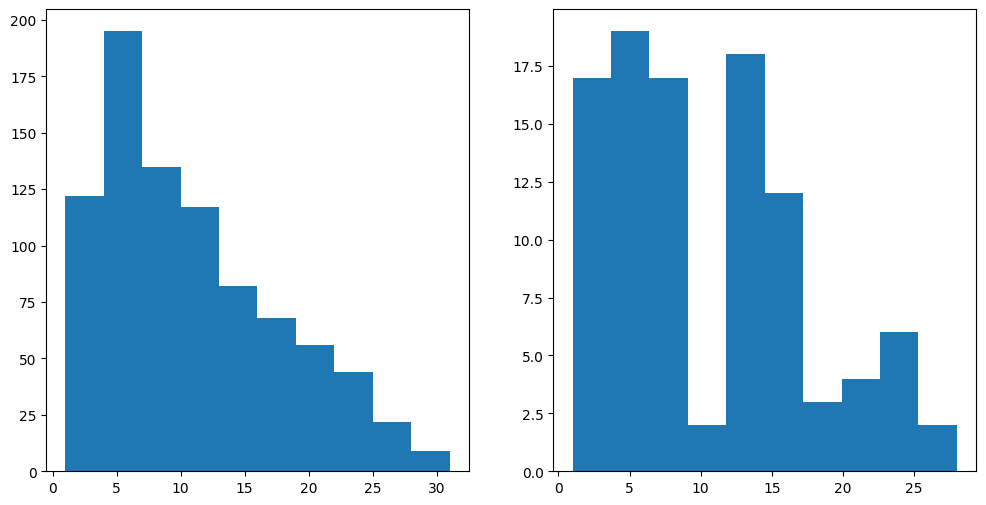

In [367]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in X_train]
test_lens = [len(s) for s in X_test]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

# 7. Sequence Normalization and Encoding Labels

In [381]:
MAX_SEQUENCE_LENGTH = 100

In [382]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
X_val = sequence.pad_sequences(X_val, maxlen=MAX_SEQUENCE_LENGTH)

In [383]:
le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [384]:
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

In [385]:
y_train

array([1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,

In [386]:
VOCAB_SIZE = len(t.word_index)

# 8. Model Preparation and Training

In [417]:
EMBED_SIZE = 300
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [418]:
Adam = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1)

In [419]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)

In [420]:
# create the model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(rate=0.10))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(rate=0.10))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(rate=0.10))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [421]:
model.compile(loss=loss, optimizer=Adam, metrics=['accuracy'])


In [422]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 100, 300)          516600    
                                                                 
 conv1d_75 (Conv1D)          (None, 100, 32)           38432     
                                                                 
 max_pooling1d_75 (MaxPooli  (None, 50, 32)            0         
 ng1D)                                                           
                                                                 
 dropout_75 (Dropout)        (None, 50, 32)            0         
                                                                 
 conv1d_76 (Conv1D)          (None, 50, 64)            8256      
                                                                 
 max_pooling1d_76 (MaxPooli  (None, 25, 64)            0         
 ng1D)                                               

In [423]:
# Fit the model
with tf.device('/GPU:0'):
    history1 = model.fit(X_train, y_train, validation_data=(X_val,y_val),epochs=10, batch_size=24, verbose=1, callbacks=[callback])

Epoch 1/10
36/36 [==============================] - 3s 42ms/step - loss: 0.6929 - accuracy: 0.4988 - val_loss: 0.6791 - val_accuracy: 0.6600
Epoch 2/10
36/36 [==============================] - 1s 37ms/step - loss: 0.5574 - accuracy: 0.7906 - val_loss: 0.4604 - val_accuracy: 0.8600
Epoch 3/10
36/36 [==============================] - 2s 47ms/step - loss: 0.2931 - accuracy: 0.9565 - val_loss: 0.4718 - val_accuracy: 0.8000
Epoch 4/10
36/36 [==============================] - 2s 54ms/step - loss: 0.2214 - accuracy: 0.9953 - val_loss: 0.4879 - val_accuracy: 0.8200
Epoch 5/10
36/36 [==============================] - 2s 59ms/step - loss: 0.2081 - accuracy: 0.9988 - val_loss: 0.4603 - val_accuracy: 0.8200
Epoch 6/10
36/36 [==============================] - 2s 52ms/step - loss: 0.2036 - accuracy: 1.0000 - val_loss: 0.4692 - val_accuracy: 0.8200
Epoch 7/10
36/36 [==============================] - 1s 35ms/step - loss: 0.2021 - accuracy: 1.0000 - val_loss: 0.4779 - val_accuracy: 0.8200
Epoch 8/10
36

# 9. Visualizing and Evaluating the Results

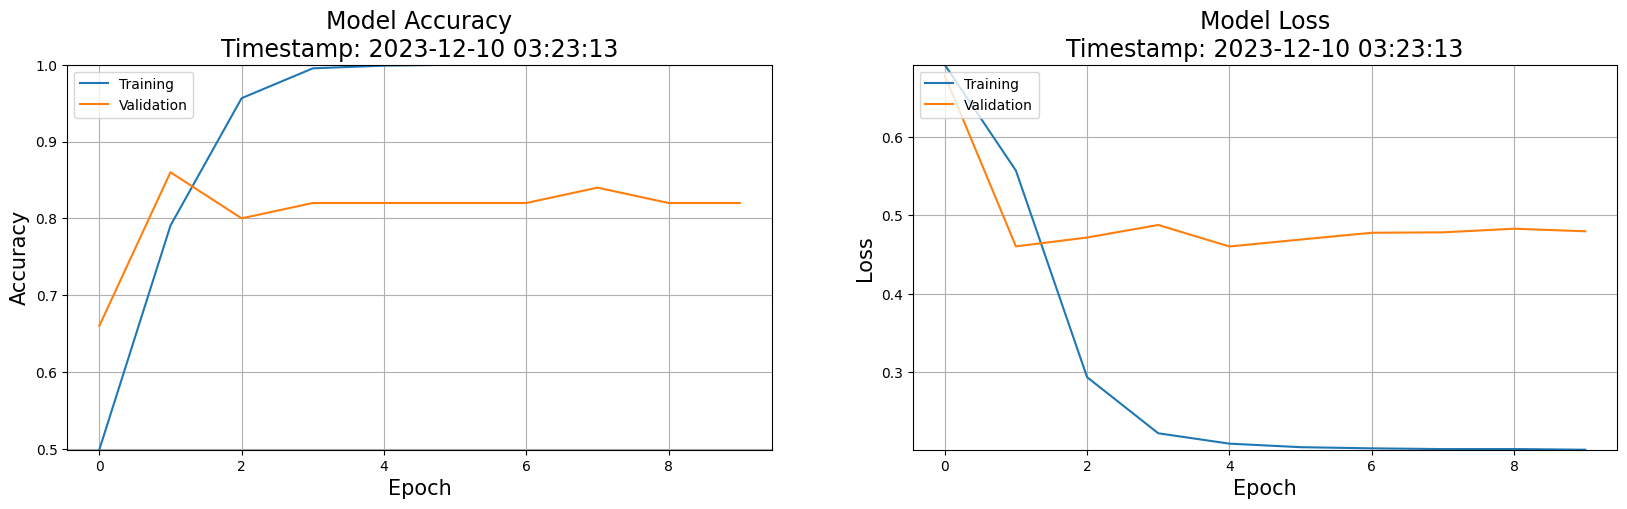

In [424]:
plot_performance(history=history1)

In [425]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

4/4 [==============================] - 0s 11ms/step - loss: 0.4784 - accuracy: 0.8500
Accuracy: 85.00%


In [428]:
pred=model.predict(X_val)
pred

2/2 [==============================] - 0s 15ms/step


array([[0.04123953],
       [0.1305739 ],
       [0.02229722],
       [0.8417476 ],
       [0.12026705],
       [0.03365974],
       [0.09282514],
       [0.03271217],
       [0.6367331 ],
       [0.08722831],
       [0.05451969],
       [0.03404892],
       [0.74491423],
       [0.91333014],
       [0.2727224 ],
       [0.89275616],
       [0.9160797 ],
       [0.0332369 ],
       [0.51436585],
       [0.04307343],
       [0.18068498],
       [0.04157137],
       [0.9256219 ],
       [0.7905161 ],
       [0.05944388],
       [0.11889455],
       [0.65071344],
       [0.9083837 ],
       [0.20073183],
       [0.06371364],
       [0.2549755 ],
       [0.8729693 ],
       [0.04881903],
       [0.93415403],
       [0.17608503],
       [0.8562306 ],
       [0.10573513],
       [0.69883156],
       [0.45529935],
       [0.8248844 ],
       [0.33674756],
       [0.7355373 ],
       [0.9136427 ],
       [0.33751222],
       [0.06726298],
       [0.05043162],
       [0.15993342],
       [0.807

In [429]:
pred_converted = [1 if x >= 0.5 else 0 for x in pred]

# Membuat DataFrame baru dengan kolom review_text dan pred
new_df = pd.DataFrame({
    'review_text': val['review_text'],
    'pred': pred_converted
})

In [430]:
new_df


,review_text,pred
979,Not enough volume.,0
959,"However, the keypads are so tinny that I somet...",0
988,"It didn't work, people can not hear me when I ...",0
985,There was so much hype over this phone that I ...,1
994,Kind of flops around.,0
999,"You can not answer calls with the unit, never ...",0
965,I cannot make calls at certain places.,0
970,I plugged it in only to find out not a darn th...,0
952,Very satisifed with that.,1
953,It didn't charge for me.,0


# 10. Saving Model

In [426]:
model.save('/content/drive/MyDrive/DEEP LEARNING/Binary_Classification_86_CNN.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [431]:
%cd /content/drive/MyDrive/DEEP LEARNING

/content/drive/MyDrive/DEEP LEARNING


In [432]:
!pip freeze > '/content/drive/MyDrive/DEEP LEARNING/requirements.txt'
